# Capgemini Datacamp - NLP Data Case

## Context:

Our client, TotalEnergies, a French energy supplier, is expecting an intensifying competition to retain customers in 2024 given the tense energy market, including but not limited to soaring energy prices.

To differentiate itself from its competitors, it wants to listen to customer feedback to better understand and meet customer needs, expectations and identify the priority pain points to solve across their customer journey.

## Goal:

As a Data Science consultant, you will have to assess the customer relationship strategy of a French energy supplier (TotalEnergies) and provide recommendations for each stage of the customer journey

- Use Natural Language Processing (NLP) approaches to listen to the Voice of the customer (VoC) and identify pain points across the entire customer journey.

- Analyze these results in light of the current tense energy market context, then assess and strategize opportunities that could benefit to both your client and its customers.

This project features a deep visual analysis and a sentiment predictor model of a Trustpilot dataset. The data consists in the first 10 pages of reviews of the company TotalEnergies scraped from the website Trustpilot. <br>
To see how the data was gathered, please check the Python script in the repository.

In [1]:
%pip install bertopic

Note: you may need to restart the kernel to use updated packages.


### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)
sns.set_palette('tab10')
%matplotlib inline
import holidays
from wordcloud import WordCloud
import re
from collections import Counter
import spacy
import time

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

from keras.preprocessing.text import Tokenizer
import torch.nn as nn
from keras.utils import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

--------------------------------------------------------------------------------------------------------------------------
# 1. Overview of the Data

### Load the dataset

In [3]:
df = pd.read_csv("Reviews_totalenergies.csv")

In [4]:
df.head()

,Date,Title,Comment,Reply,Rating
0,2024-02-08,Pour 20€ de réduc x2 Codes parrain 105422076 e...,"Bonjour,Je partage mes codes parrain au choix ...",NaN,5
1,2024-01-01,pas si pire que ça !,positif: - bon site web pour suivi- pas de cou...,"Bonjour Monsieur,J'ai bien pris en compte votr...",3
2,2024-02-04,"Pas de coupures, 100% verte mais reste honeure...","Le fait d'être 100% vert, éolienne et solaire ...",NaN,4
3,2023-07-06,Moins cher que edf,Moins cher que edf. J'aime bien sérieux sav ré...,NaN,4
4,2024-02-01,Je suis chez Total énergie depuis 4 ans…,Je suis chez Total énergie depuis 4 ans et auc...,NaN,5


In [5]:
df.tail()

,Date,Title,Comment,Reply,Rating
995,2022-09-10,Très satisfait avec facilité de…,"Très satisfait avec facilité de souscription, ...",NaN,5
996,2022-09-09,Ma souscription avec total énergie par…,Ma souscription avec total énergie par appel t...,NaN,5
997,2022-09-04,Je suis ravi des présentations et je…,Je suis ravi des présentations et je remercie ...,NaN,5
998,2022-09-08,Personne très a l écoute,"Personne très a l écoute, disponible ayant pri...",NaN,4
999,2022-09-10,contact aimable,"contact aimable , explication clair",NaN,5


In [6]:
df.shape

(1000, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     1000 non-null   object
 1   Title    1000 non-null   object
 2   Comment  905 non-null    object
 3   Reply    358 non-null    object
 4   Rating   1000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


In [8]:
df.duplicated().sum()

0

In [9]:
df.isna().sum()

Date         0
Title        0
Comment     95
Reply      642
Rating       0
dtype: int64

In [10]:
df.nunique()

Date       439
Title      949
Comment    905
Reply      327
Rating       5
dtype: int64

In [11]:
df.dtypes

Date       object
Title      object
Comment    object
Reply      object
Rating      int64
dtype: object

In [12]:
# Convert Date feature to datetime

df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.dtypes

Date       datetime64[ns]
Title              object
Comment            object
Reply              object
Rating              int64
dtype: object

In [14]:
# Timestamp information
print("\nTimestamp information:")
earliest_time = df['Date'].min()
latest_time = df['Date'].max()
print(f"Earliest Time: {earliest_time}")
print(f"Latest Time: {latest_time}")


Timestamp information:
Earliest Time: 2021-10-01 00:00:00
Latest Time: 2024-02-08 00:00:00


### Observations:

We extracted the latest 1000 reviews (from Oct. 2021 until Feb. 2024) of TotalEnergies on Trustpilot with 5 features including:
- The `Date` of the comment
- The `Title` of the comment
- The `Comment`
- The `Reply` (if applicable)
- The `Rating` given by the consumer.

There are a few missing values in the `Comment` variable as some customers can give a rating without writing a comment, which we'll need to take care of for further analysis.

--------------------------------------------------------------------------------------
# 2. Exploratory Data Analysis

### Count `Rating`

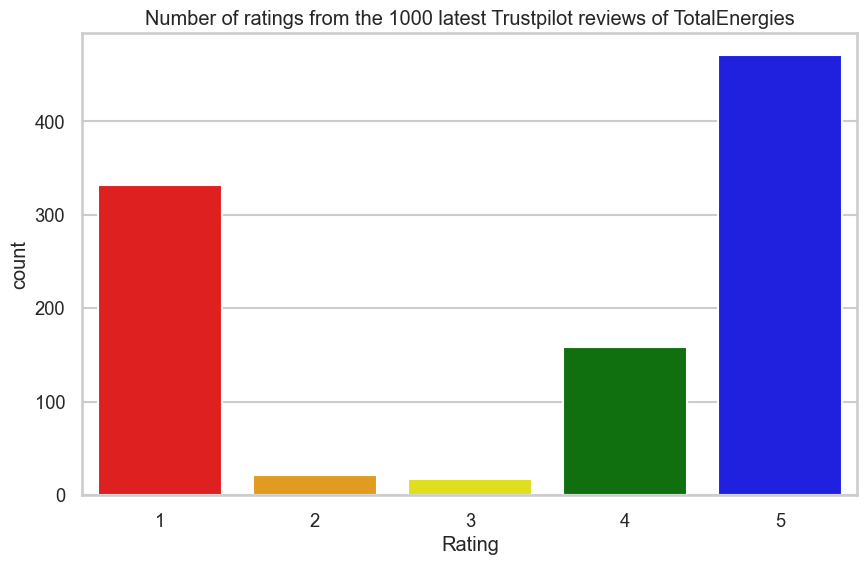

In [15]:
# Define a custom color palette for each sentiment
colors = {1: "red", 2: "orange", 3: "yellow", 4: "green", 5: "blue"}
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Rating", palette=colors)
plt.title(f"Number of ratings from the {df.shape[0]} latest Trustpilot reviews of TotalEnergies")
#plt.savefig('rating_count.png')
plt.show()

In [16]:
df['Rating'].value_counts()

5    471
1    332
4    158
2     22
3     17
Name: Rating, dtype: int64

In [17]:
df['Rating'].value_counts(normalize=True)

5    0.471
1    0.332
4    0.158
2    0.022
3    0.017
Name: Rating, dtype: float64

**Observations:**

The majority of the customers had either an excellent (4-5) or a terrible experience (1) with this company. Although, a lot of customers seem very satisfied, giving 5 stars rating.

### Create `Sentiment` based on `Rating`

We create the `Sentiment` variable. 

We label as **Negative** all the reviews with less than 3 stars, as **Positive** those with more than 3, and as **Neutral** those with exactly 3 stars. 

In [18]:
def set_sentiment(value):
    if value < 3:
        value = "Negative"
    elif value > 3:
        value = "Positive"
    else:
        value = "Neutral"
    return value

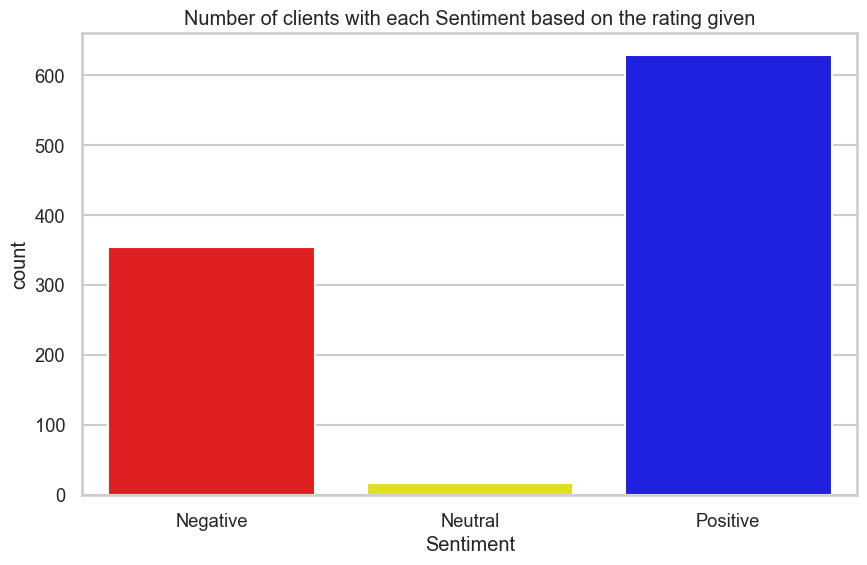

In [19]:
# Create Sentiment column
df["Sentiment"] = df["Rating"].apply(lambda x: set_sentiment(x))

# Define a custom color palette for each sentiment
colors = {"Positive": "blue", "Negative": "red", "Neutral": "yellow"}

plt.figure(figsize=(10, 6))
# Plot the countplot with the custom color palette
sns.countplot(data=df, x="Sentiment", palette=colors, order=["Negative", "Neutral", "Positive"])

# Add a title
plt.title("Number of clients with each Sentiment based on the rating given")

#plt.savefig('sentiment_count.png')
# Show the plot
plt.show()

In [20]:
df['Sentiment'].value_counts()

Positive    629
Negative    354
Neutral      17
Name: Sentiment, dtype: int64

In [21]:
df["Sentiment"].value_counts(normalize = True)

Positive    0.629
Negative    0.354
Neutral     0.017
Name: Sentiment, dtype: float64

**Observations:**

There are a lot more positive reviews than negative ones. 

### Box Plots based on length and number of words

The following boxplots show the reviews' length measured as the number of characters per each sentiment. 

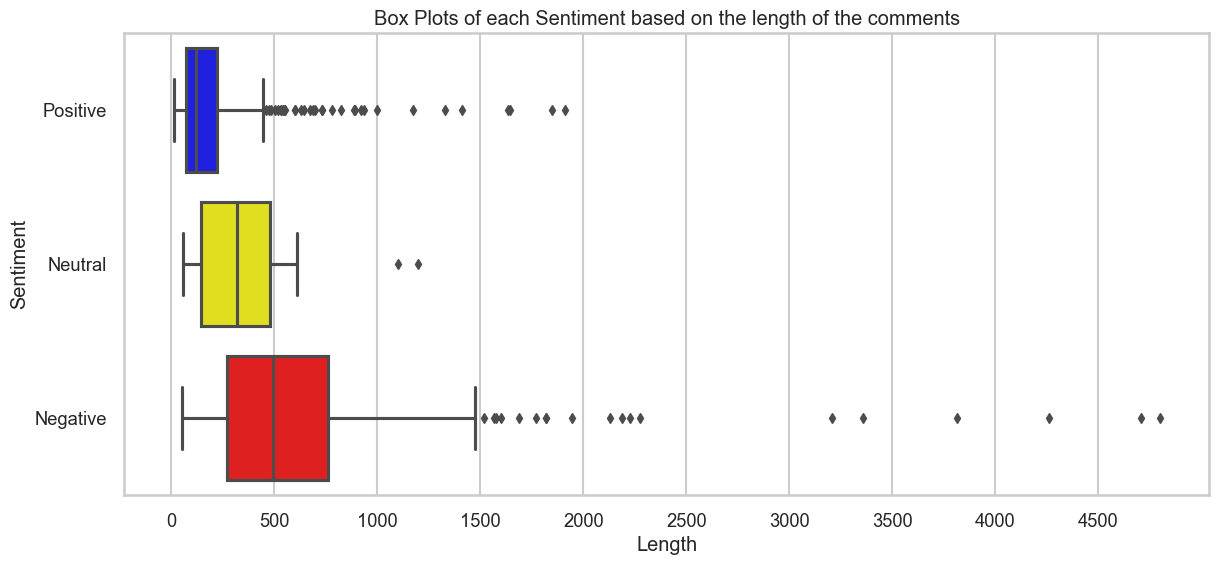

In [22]:
df["Length"] = df["Comment"].str.len()

plt.figure(figsize=(14,6))
sns.boxplot(data=df, y = "Sentiment", x = "Length", orient="h", palette=colors)
plt.xticks(np.arange(0, 5000, 500))
plt.title("Box Plots of each Sentiment based on the length of the comments")
#plt.savefig('boxplot_sentiment_vs_length.png')
plt.show()

**Observations:**

Negative reviews tend to be much longer. We can also notice how the vast majority of the reviews have less than 1000 characters.

In [23]:
# Drop missing values (comments)
df.dropna(subset='Comment', inplace=True)

# Number of words column
df["nb_words"] = df["Comment"].apply(lambda x: len(x.split(" ")))

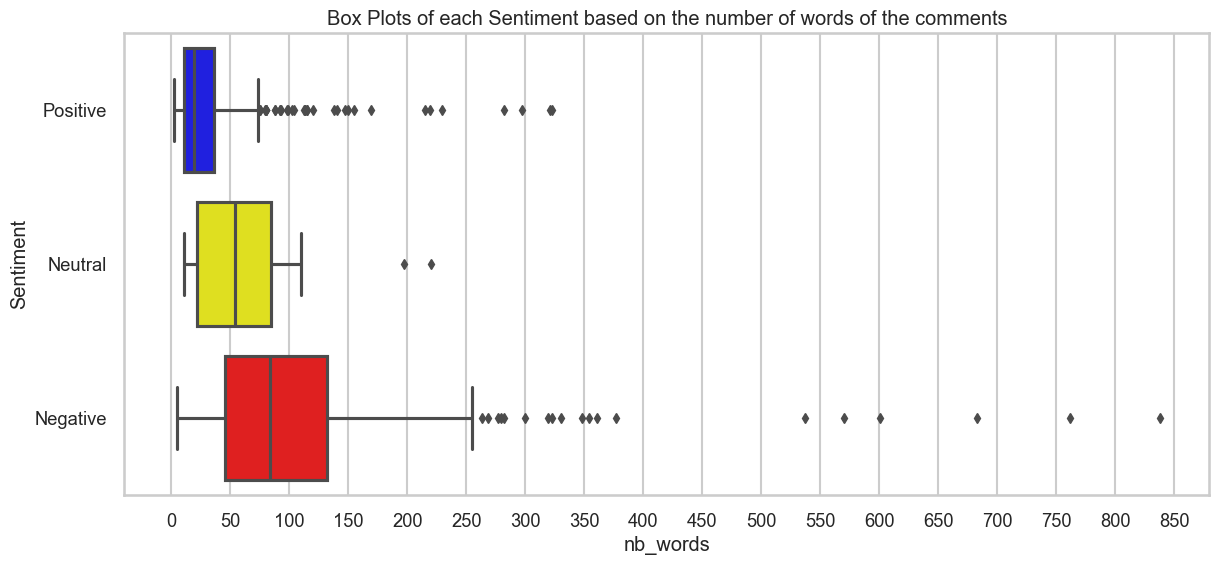

In [24]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, y = "Sentiment", x = "nb_words", orient="h", palette=colors)
plt.xticks(np.arange(0, 900, 50))
plt.title("Box Plots of each Sentiment based on the number of words of the comments")
#plt.savefig('boxplot_sentiment_vs_nb_words.png')
plt.show()

**Observations:**

Similarly, in general, negative comments have many words expressing their dissatisfaction.

--------------------------------------------------------------------------------------
# 3. Feature Engineering

### Remove Neutral Comments

Since there is only around 1% of neutral ratings, we will drop neutral rows to simplify our problem to a binary classification.

In [25]:
df = df[df["Sentiment"]!="Neutral"]
df.reset_index(inplace=True, drop=True)

### Date Features Extraction

In [26]:
# Define a function to map months to seasons
def get_season(month):
    """
    Map a given month to a corresponding season.

    Parameters:
    - month (int): Numeric representation of the month (1 to 12).

    Returns:
    - str: The season associated with the input month. Possible values are 'Spring', 'Summer', 'Fall', or 'Winter'.

    Example:
    >>> get_season(7)
    'Summer'

    Note:
    The function considers the following month ranges for each season:
    - Spring: March (3) to May (5)
    - Summer: June (6) to August (8)
    - Fall: September (9) to November (11)
    - Winter: December (12), January (1), and February (2)
    """
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter' # December, January, February

In [27]:
def encode_dates(df):
    """
    Encode temporal features from a given DataFrame containing a 'date' column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with a 'date' column of datetime type.

    Returns:
    - pd.DataFrame: DataFrame with additional columns encoding temporal features, including:
        - 'year': Year extracted from the 'date' column.
        - 'month': Month extracted from the 'date' column.
        - 'day': Day of the month extracted from the 'date' column.
        - 'hour': Hour of the day extracted from the 'date' column.
        - 'weekday': Numeric representation of the day of the week (0 for Monday, 6 for Sunday).
        - 'season': Season associated with the 'month' column using the get_season function.
        - 'working_day': Binary indicator for working days (1 for weekdays not in French holidays, 0 otherwise).
        - 'school_holiday': Binary indicator for school holidays using the is_school_holiday function.

    Raises:
    - ValueError: If the input DataFrame does not have a 'date' column or if the 'date' column is not of datetime type.
    """
    if 'Date' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['Date']):
        raise ValueError("DataFrame must have a 'date' column of datetime type.")

    X = df.copy()

    # Extracting date components
    X['year'] = X['Date'].dt.year
    X['month'] = X['Date'].dt.month
    X['day'] = X['Date'].dt.day
    X['hour'] = X['Date'].dt.hour
    X['weekday'] = X['Date'].dt.weekday

    # Adding season based on month
    X['season'] = X['month'].apply(get_season)

    # Identifying working days (weekdays not in French holidays)
    fr_holidays = holidays.France()
    X['working_day'] = ((X['Date'].dt.weekday < 5) & ~X['Date'].dt.date.isin(fr_holidays)).astype(int)

    return X

In [28]:
# Record the start time
start_time = time.time()

df = encode_dates(df)

# Record the end time
end_time = time.time()

# Calculate the runtime
runtime = round(end_time - start_time, 2)

# Print the runtime
print(f"Runtime: {runtime} seconds")
df.head()

Runtime: 0.13 seconds


,Date,Title,Comment,Reply,Rating,Sentiment,Length,nb_words,year,month,day,hour,weekday,season,working_day
0,2024-02-08,Pour 20€ de réduc x2 Codes parrain 105422076 e...,"Bonjour,Je partage mes codes parrain au choix ...",NaN,5,Positive,1329.0,215,2024,2,8,0,3,Winter,1
1,2024-02-04,"Pas de coupures, 100% verte mais reste honeure...","Le fait d'être 100% vert, éolienne et solaire ...",NaN,4,Positive,485.0,80,2024,2,4,0,6,Winter,0
2,2023-07-06,Moins cher que edf,Moins cher que edf. J'aime bien sérieux sav ré...,NaN,4,Positive,145.0,24,2023,7,6,0,3,Summer,1
3,2024-02-01,Je suis chez Total énergie depuis 4 ans…,Je suis chez Total énergie depuis 4 ans et auc...,NaN,5,Positive,474.0,80,2024,2,1,0,3,Winter,1
4,2024-02-05,ATROCE,"ATROCE, A éviter, ça fonctionne si mal !! Il n...","Bonjour Monsieur,J'ai bien pris en compte vot...",1,Negative,397.0,64,2024,2,5,0,0,Winter,1


### Text Processing

Let's now take a look at what the full first 5 reviews look like:

In [29]:
for i in range(5):
    print(df["Comment"][i])
    print("\n")

Bonjour,Je partage mes codes parrain au choix le105422076et l'autre105175969car il est possible d'avoir deux codes parrains quand on a deux contrats distincts (gaz + électricité par exemple) chez TotalEnergies.On récupère 20 euros de gains que l'on soit le parrain ou le parrainé en déduction des factures; c'est important.Pour vous aider à ne pas vous perdre, je vous mets les démarches à suivre: taper sur google "TotalEnergies comment souscrire" et sélectionnez le 1er résultat de la recherche "Souscrire à TotalEnergies".Au bout d'un moment vous arriverez alors aux étapes suivantes qui vous permettront d'entrée au choix mes codes parrain et valider pour bénéficier de 20 €:- Au niveau de "je choisis mon code avantage", Cliquer sur la petite boule bleue "J'ai un code promo ou parrainage" apparaisse - Saisissez dans le cadre "Mon code parrain ou code promo"au choix le code 105422076 ou le 105175969 - Cliquer sur "Ok"Vous verrez alors le message de validation de ces codes actifs (au choix) "

To make this data suitable for a ML model we'll need to preprocess it: the texts need to be converted into lowercase and have to be clean of special characters and punctuation.

In [30]:
# Define a function to replace punctuation with spaces
def replace_punctuation(comment):
  if isinstance(comment, str):
    return ''.join([' ' if c in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' else c for c in comment])
  else:
    return comment

# Apply the punctuation replacement function to the "Comment" and "Reply" column for both Eni and TotalEnergies

def preprocess_column(df, column):
    df[column] = df[column].apply(replace_punctuation)
    df[column] = df[column].str.lower()

preprocess_column(df, 'Comment')

In [31]:
# Print the same reviews above after converting to lowercase and removing special characters and punctuation
for i in range(5):
    print(df["Comment"][i])
    print("\n")

bonjour je partage mes codes parrain au choix le105422076et l autre105175969car il est possible d avoir deux codes parrains quand on a deux contrats distincts  gaz   électricité par exemple  chez totalenergies on récupère 20 euros de gains que l on soit le parrain ou le parrainé en déduction des factures  c est important pour vous aider à ne pas vous perdre  je vous mets les démarches à suivre  taper sur google  totalenergies comment souscrire  et sélectionnez le 1er résultat de la recherche  souscrire à totalenergies  au bout d un moment vous arriverez alors aux étapes suivantes qui vous permettront d entrée au choix mes codes parrain et valider pour bénéficier de 20 €   au niveau de  je choisis mon code avantage   cliquer sur la petite boule bleue  j ai un code promo ou parrainage  apparaisse   saisissez dans le cadre  mon code parrain ou code promo au choix le code 105422076 ou le 105175969   cliquer sur  ok vous verrez alors le message de validation de ces codes actifs  au choix   

Moreover, many common words such as articles, auxiliary verbs and conjuctions have to be removed to avoid feeding the model with too much noise. We use the `spacy` library to clean our text data.

In [32]:
# Load a pre-trained language model (e.g., French)
nlp = spacy.load("fr_core_news_sm")

# Process text
def tokenize_lemm_func(text):
    # Analyze text with spacy
    doc = nlp(text)

    # Lemmatization and stop words removal
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]

    # Join the tokenized words as a sequence to form back the processed text
    lemmatized_text = ' '.join(lemmatized_tokens)

    return lemmatized_text

df["Comment_clean"] = df["Comment"].apply(tokenize_lemm_func)

In [33]:
# Print the same reviews above after the removing stop words and lemmatization:
for i in range(5):
    print(df["Comment_clean"][i])
    print("\n")

bonjour partager code parrain choix le105422076et l autre105175969car d code parrain contrat distinct   gaz    électricité exemple   totalenergie récupérer 20 euro gain l parrain parrainé déduction facture   c important aider perdre   mettre démarche   taper google   totalenergie souscrir   sélectionner premier résultat recherche   souscrir totalenergie   bout d moment arriver étape permettre d entrée choix code parrain valider bénéficier 20 euro    niveau   choisir code avantage    cliquer petit boul bleu   j code promo parrainage   apparaître    saisir cadre   code parrain code promo choix code 105422076 105175969    cliquer   ok voir message validation code actif   choix     code parrain valider   20 euro offert facture    client année totalenergie   j j moment trouver c cher   suite perte d emploi cours casino   parrainnage permettre payer facture   soutien


d 100   vert   éolien solaire devoir m assurer payer réel consommation   chose l écologie protéger augmentation prix l élect

We have another problem where some words are now only 1 character long (e.g. "j", or "m"). We need to remove those words to not influence our analysis.

In [34]:
# Function to remove one-character words
def remove_one_char_words(text):
    # Split the text into words
    words = text.split()

    # Filter out one-character words
    filtered_words = [word for word in words if len(word) > 1]

    # Join the filtered words back into a string
    filtered_text = ' '.join(filtered_words)

    return filtered_text

# Apply the function to the 'Text' column
df['Comment_clean'] = df['Comment'].apply(remove_one_char_words)

In [35]:
# Print the same reviews above after removing one-character words:
for i in range(5):
    print(df["Comment_clean"][i])
    print("\n")

bonjour je partage mes codes parrain au choix le105422076et autre105175969car il est possible avoir deux codes parrains quand on deux contrats distincts gaz électricité par exemple chez totalenergies on récupère 20 euros de gains que on soit le parrain ou le parrainé en déduction des factures est important pour vous aider ne pas vous perdre je vous mets les démarches suivre taper sur google totalenergies comment souscrire et sélectionnez le 1er résultat de la recherche souscrire totalenergies au bout un moment vous arriverez alors aux étapes suivantes qui vous permettront entrée au choix mes codes parrain et valider pour bénéficier de 20 au niveau de je choisis mon code avantage cliquer sur la petite boule bleue ai un code promo ou parrainage apparaisse saisissez dans le cadre mon code parrain ou code promo au choix le code 105422076 ou le 105175969 cliquer sur ok vous verrez alors le message de validation de ces codes actifs au choix code parrain validé 20€ offerts sur ma première fac

------------------------------------------------------------------------
# 4. Post-Processing Visualizations

### Count unique words in positive and negative reviews

Now that our data is ready, we can dive into some further data analysis. The following histogram shows the number of unique words used for both positive and negative reviews.

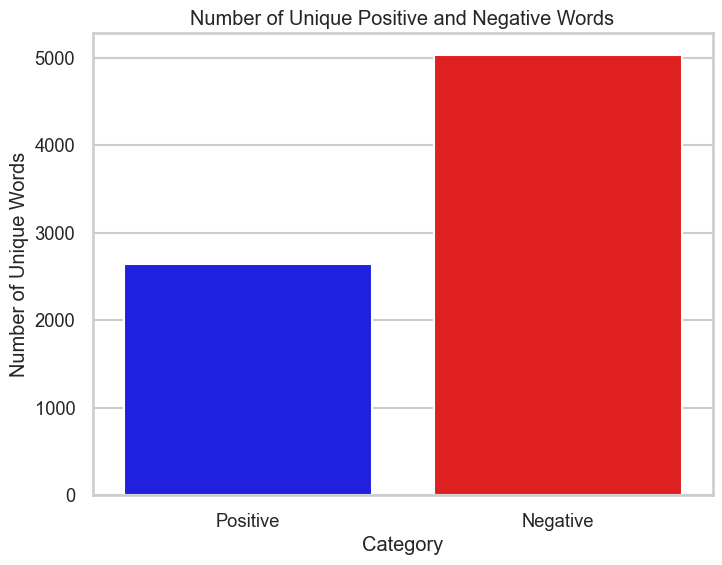

In [36]:
df["Split"] = df["Comment"].apply(lambda x:str(x).split())

df_pos = df[df["Sentiment"]=="Positive"]
df_neg = df[df["Sentiment"]=="Negative"]

pos_words = Counter([item for sublist in df_pos["Split"] for item in sublist])
neg_words = Counter([item for sublist in df_neg["Split"] for item in sublist])

unique_pos_words = len(pos_words)
unique_neg_words = len(neg_words)

unique = pd.DataFrame({'Category': ['Positive', 'Negative'],
                     'Count': [unique_pos_words, unique_neg_words]})

colors = {'Positive': 'blue', 'Negative': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=unique, palette=colors)
plt.title("Number of Unique Positive and Negative Words")
plt.xlabel("Category")
plt.ylabel("Number of Unique Words")
#plt.savefig('unique_pos_neg_words.png')
plt.show()

**Observations:**

Negative reviews tend to have a broader lexicon, which is surely correlated to the fact that, as we saw from the boxplots, negative reviews are also longer by norm.

### Most used words in positive and negative reviews

Let's see what are the 25 most used words in both types of reviews.

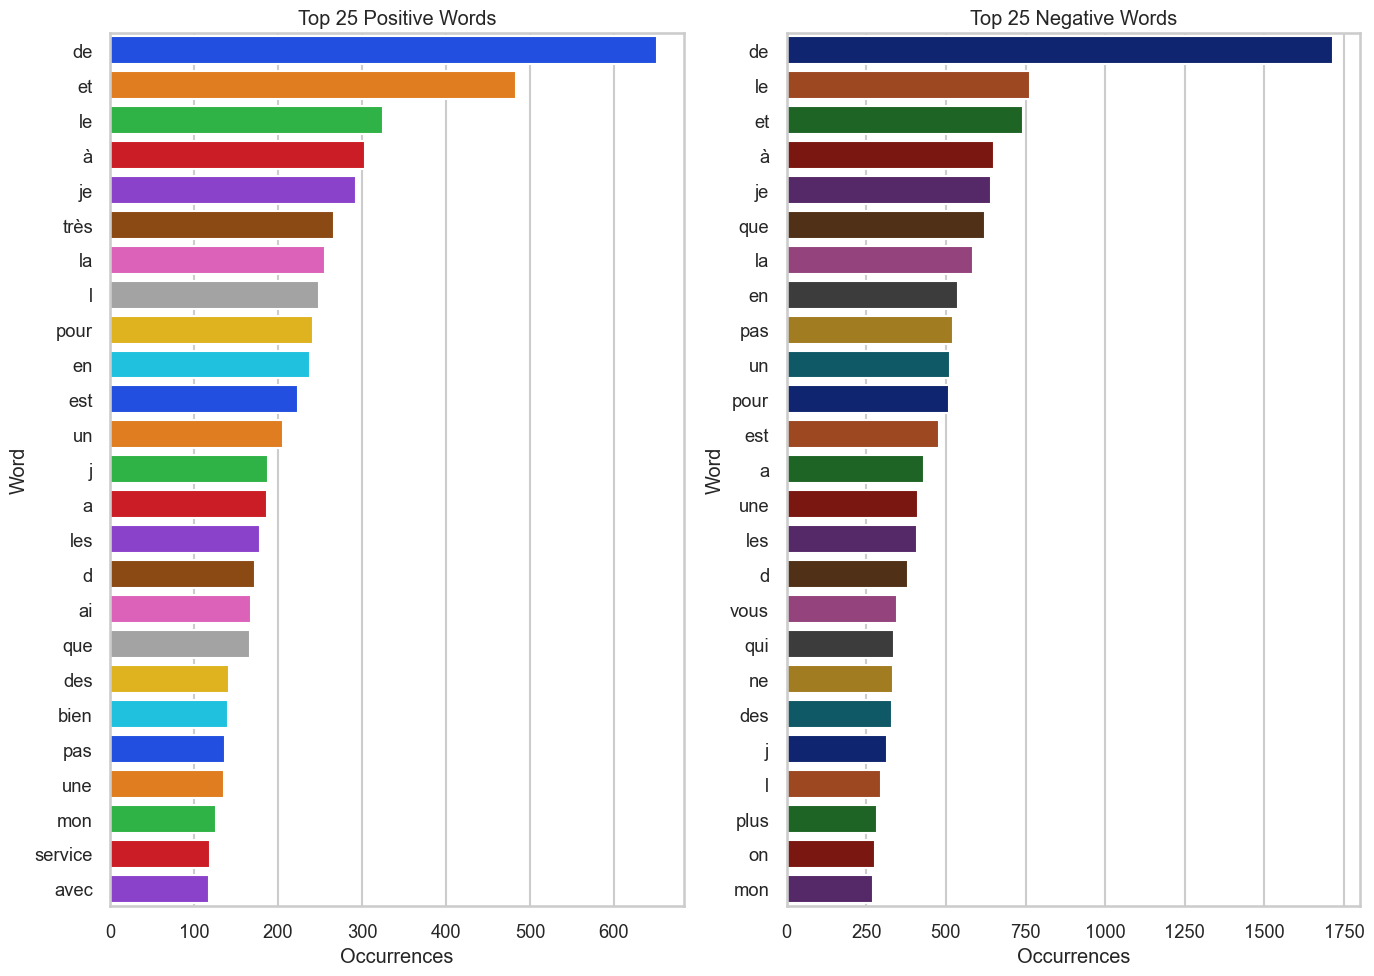

In [37]:
top_pos = pd.DataFrame(pos_words.most_common(25))
top_pos.columns = ["Word", "Occurrences"]
top_neg = pd.DataFrame(neg_words.most_common(25))
top_neg.columns = ["Word", "Occurrences"]

fig, axs = plt.subplots(1, 2, figsize = (14, 10))

sns.barplot(data=top_pos, x="Occurrences", y="Word", ax=axs[0], orient="h", palette="bright")
axs[0].set_title("Top 25 Positive Words")
sns.barplot(data=top_neg, x="Occurrences", y="Word", ax=axs[1], orient="h", palette="dark")
axs[1].set_title("Top 25 Negative Words")
plt.tight_layout()
#plt.savefig('top30_pos_neg_words.png')
plt.show()

**Observations:**

It doesn't come as a surprise that words such as "bien", "bon" or "rapide" are way more common in positive reviews. Negative reviews tend to have more words that express negation such as "ne", or related to the service's quality such as "service", "contrat" and "probleme".

### Wordclouds

In [38]:
def show_wordcloud(data, sentiment=None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 50,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')

    if sentiment.lower() == 'positive':
        plt.savefig('wordcloud_pos.png')
    
    elif sentiment.lower() == 'negative':
        plt.savefig('wordcloud_neg.png')
    
    else:
        plt.savefig('wordcloud.png')
        
    plt.show()

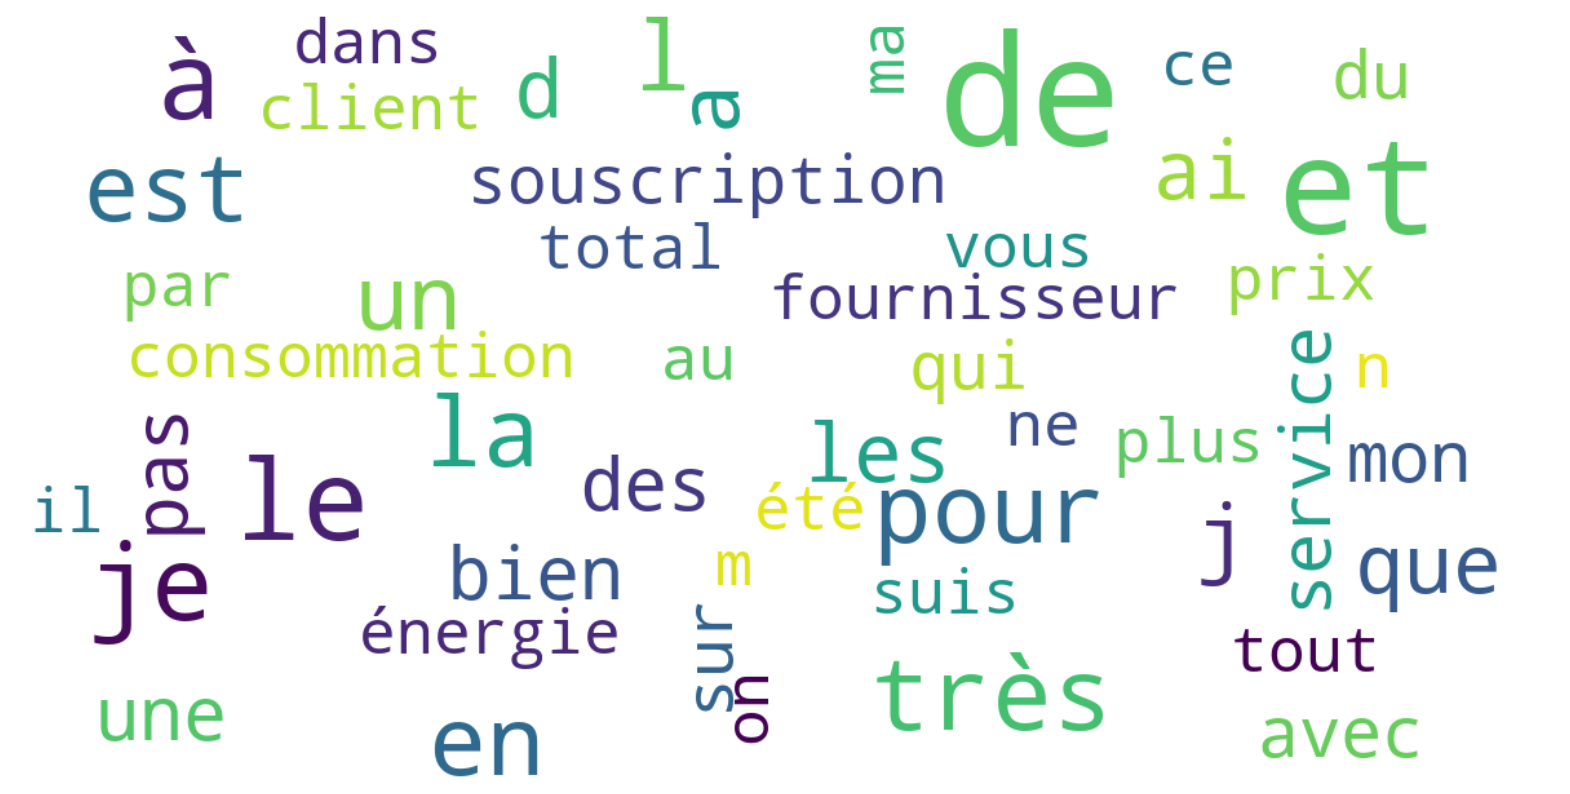

In [39]:
# wordcloud for positive reviews
show_wordcloud(pos_words, sentiment='positive')

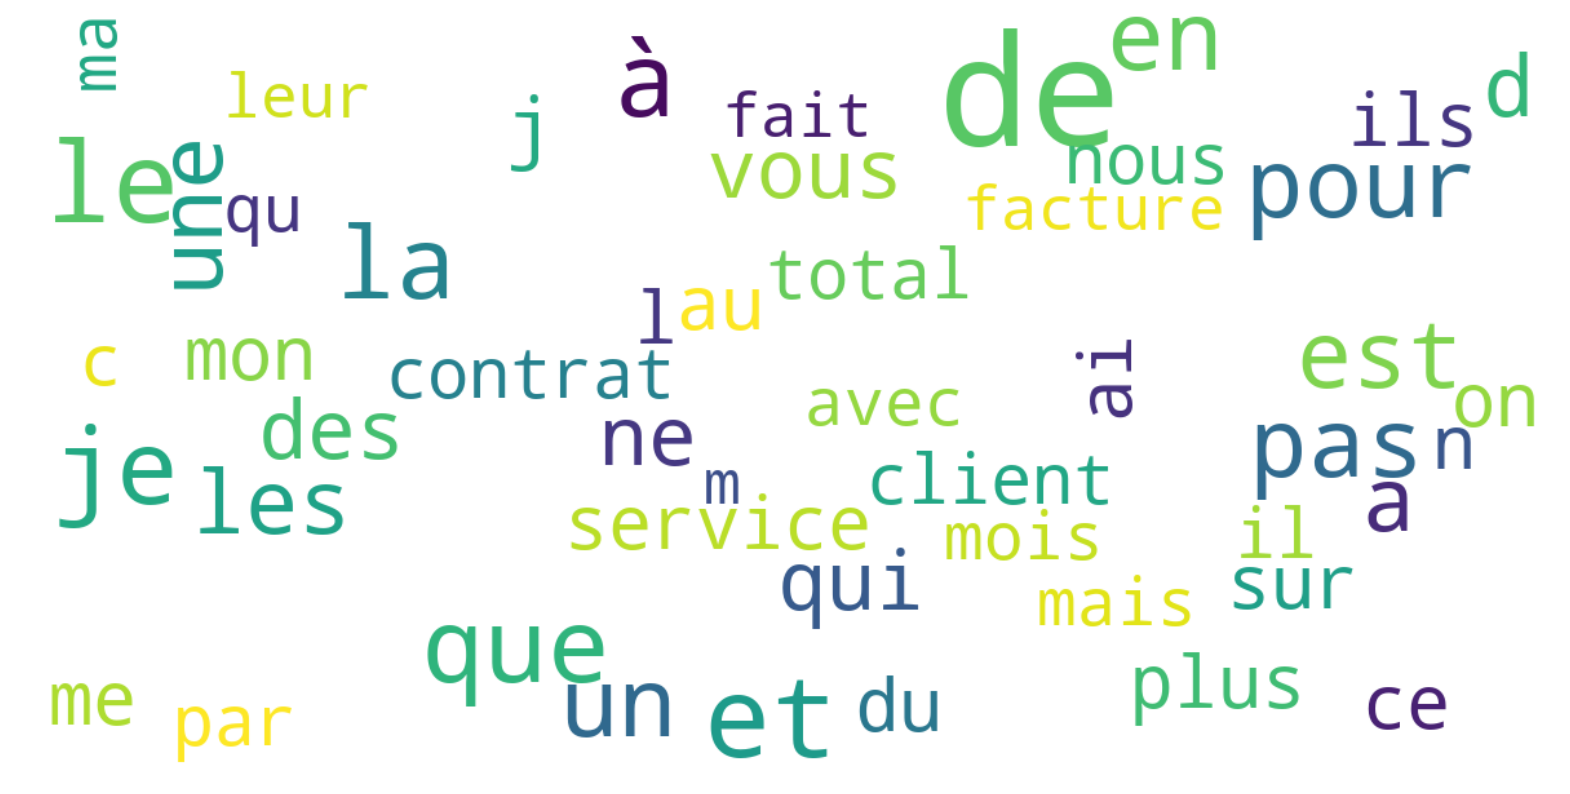

In [40]:
# wordcloud for negative reviews
show_wordcloud(neg_words, sentiment='negative')

-------------------------------------------------------------------------------
# Key Performance Indicators

### Evolution of ratings over time

Now we can look at temporal analysis, to see if reviews got worse over time or if there is a specific period where reviews dropped.

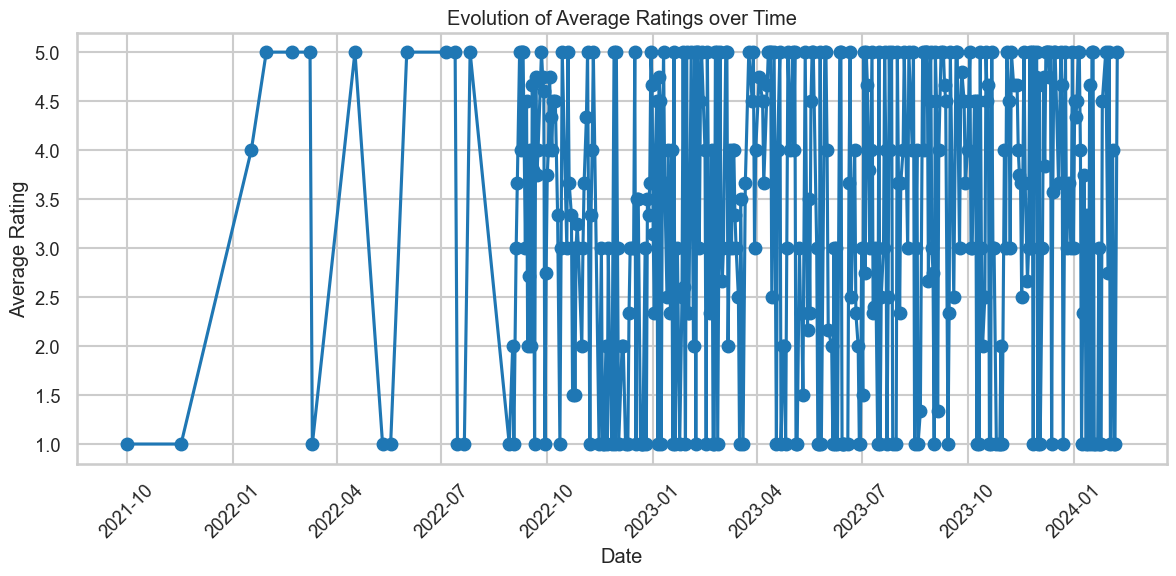

In [41]:
# Group by date and calculate the mean rating
ratings_by_date = df.groupby('Date')['Rating'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ratings_by_date['Date'], ratings_by_date['Rating'], marker='o', linestyle='-')
plt.title('Evolution of Average Ratings over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

We have way too many dates so it is hard to find any trends or patterns. We will focus only in the last 6 months (starting Sep. 2023) and take the weekly average to have a clearer visualization.

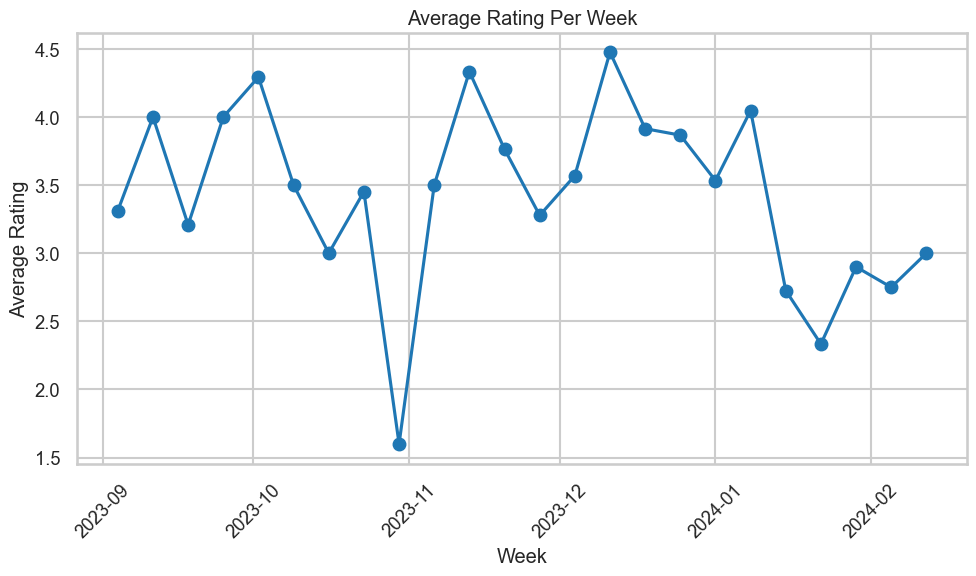

In [42]:
df_after_sep_2023 = ratings_by_date.query("Date >= '2023-09-01'")

# Group by week and calculate average rating
df_weekly_avg = df_after_sep_2023.resample('W-Mon', on='Date').mean().reset_index()

# Plot the evolution of average rating per week
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_avg['Date'], df_weekly_avg['Rating'], marker='o')
plt.title('Average Rating Per Week')
plt.xlabel('Week')
plt.ylabel('Average Rating')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observations:**

While there doesn't appear to be any trend in the ratings, we notice a big drop in the first week of November. The average ratings is fairly stable (moving around 3.5 and 4). However, we notice that recently, starting January 2024, the average rating has dropped below 3.0.

### Response Rate / Time

In [43]:
df_replies = df[df['Reply'].notna()]
df_replies

,Date,Title,Comment,Reply,Rating,Sentiment,Length,nb_words,year,month,day,hour,weekday,season,working_day,Comment_clean,Split
4,2024-02-05,ATROCE,atroce a éviter ça fonctionne si mal il n...,"Bonjour Monsieur,J'ai bien pris en compte vot...",1,Negative,397.0,64,2024,2,5,0,0,Winter,1,atroce éviter ça fonctionne si mal il ne est p...,"[atroce, a, éviter, ça, fonctionne, si, mal, i..."
7,2024-01-31,Client 113648243 vente dissimulée de service,client 113648243 depuis mon emménagement dans...,"Bonjour Monsieur,J’ai bien pris note de votre ...",1,Negative,578.0,97,2024,1,31,0,2,Winter,1,client 113648243 depuis mon emménagement dans ...,"[client, 113648243, depuis, mon, emménagement,..."
13,2024-01-12,Ne vous abonnez pas chez Total Energie,ne vous abonnez pas chez total energie ce son...,"Bonjour Monsieur,J'ai bien pris en compte votr...",1,Negative,217.0,35,2024,1,12,0,4,Winter,1,ne vous abonnez pas chez total energie ce sont...,"[ne, vous, abonnez, pas, chez, total, energie,..."
16,2024-01-31,Prestations à gogo,abonnée depuis 4 ans je quitte en mon domicil...,"Bonjour Monsieur,J’ai bien pris note de votre...",1,Negative,814.0,149,2024,1,31,0,2,Winter,1,abonnée depuis ans je quitte en mon domicile c...,"[abonnée, depuis, 4, ans, je, quitte, en, mon,..."
25,2024-01-24,Pour rectifier mon avis du 05.01.24,pour rectifier mon avis du 05 01 24 je tiens ...,"Bonjour Madame,J'ai bien pris en compte votre ...",1,Negative,605.0,99,2024,1,24,0,2,Winter,1,pour rectifier mon avis du 05 01 24 je tiens p...,"[pour, rectifier, mon, avis, du, 05, 01, 24, j..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,2022-09-15,Service après vente lamentable.,service après vente lamentable installation ph...,"Bonjour,J'ai bien pris en compte votre avis et...",1,Negative,856.0,147,2022,9,15,0,3,Fall,1,service après vente lamentable installation ph...,"[service, après, vente, lamentable, installati..."
874,2022-09-14,Refus de remboursement somme prélevé sur mm co...,comme chaque années il refuse de vs remboursé ...,"Bonjour Madame,J'ai bien pris en compte votre ...",1,Negative,738.0,131,2022,9,14,0,2,Fall,1,comme chaque années il refuse de vs remboursé ...,"[comme, chaque, années, il, refuse, de, vs, re..."
879,2022-09-12,Ma résiliation a été un calvaire,quand on est client c est ok mais ma résiliat...,"Bonjour,J'ai bien pris en compte votre avis et...",1,Negative,1601.0,279,2022,9,12,0,0,Fall,1,quand on est client est ok mais ma résiliation...,"[quand, on, est, client, c, est, ok, mais, ma,..."
881,2022-09-12,Factures abusives,evaluation des factures surestimée malgré l au...,"Bonjour,J'ai bien pris en compte votre avis et...",1,Negative,282.0,42,2022,9,12,0,0,Fall,1,evaluation des factures surestimée malgré auto...,"[evaluation, des, factures, surestimée, malgré..."


In [44]:
df_replies['Rating'].value_counts()

1    318
2     22
4      1
Name: Rating, dtype: int64

In [45]:
df['Rating'].value_counts()

5    396
1    332
4    141
2     22
Name: Rating, dtype: int64

TotalEnergies replied to 318 1-star reviews out of 332 (14 were unreplied). However, they replied to all 22 2-star reviews and 1 4-star review.

While we did not retrieve the date of the replies, when checking on Trustpilot manually, we noticed they take on average around one business day to reply.

### Customer Satisfaction Score

Customer Satisfaction Score (CSAT) is a metric used by businesses to gauge the satisfaction levels of their customers based on their experiences with products, services, or interactions. Typically measured through surveys asking customers to rate their satisfaction on a scale, CSAT scores are expressed as percentages or numerical values representing the proportion of satisfied customers out of the total respondents. These scores provide valuable insights into customer sentiment, enabling businesses to identify areas for improvement, track changes in satisfaction over time, and benchmark their performance against industry standards or competitors, ultimately driving efforts to enhance overall customer experience and loyalty.

In [46]:
# Define satisfaction criteria (e.g., ratings of 4 or 5)
satisfied_criteria = [4, 5]

# Count satisfied responses
satisfied_responses = df['Rating'].isin(satisfied_criteria).sum()

# Total number of responses
total_responses = len(df)

# Compute CSAT percentage
csat_percentage = (satisfied_responses / total_responses) * 100

print("Number of satisfied responses:", satisfied_responses)
print("Total number of responses:", total_responses)
print("CSAT percentage:", str(np.round(csat_percentage, 2)) + "%")


Number of satisfied responses: 537
Total number of responses: 891
CSAT percentage: 60.27%


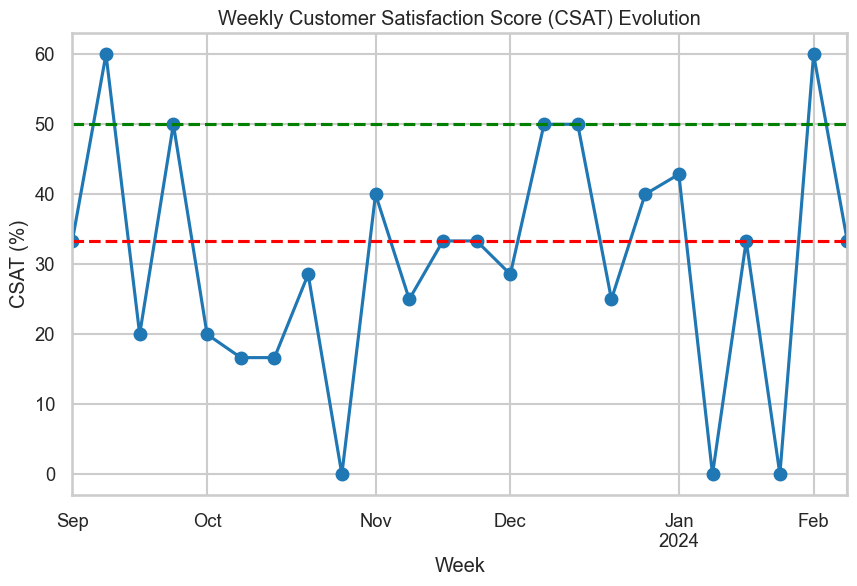

In [47]:
# Function to compute CSAT for a given week
def compute_csat(group):
    satisfied_responses = group['Rating'].isin(satisfied_criteria).sum()
    total_responses = len(group)
    csat_percentage = (satisfied_responses / total_responses) * 100
    return csat_percentage

# Compute CSAT for each week
weekly_csat = df_after_sep_2023.groupby(pd.Grouper(key='Date', freq='W')).apply(compute_csat)

# Plot the CSAT evolution over time
weekly_csat.plot(kind='line', figsize=(10, 6), marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('CSAT (%)')
plt.title('Weekly Customer Satisfaction Score (CSAT) Evolution')

plt.axhline(y=33.33, color='r', linestyle='--', label='1/3')
plt.axhline(y=50, color='g', linestyle='--', label='0.5')

plt.grid(True)
plt.show()


**Observations:**

For the past 6 months, the CSAT has been fluctuating quite a lot. There are a few weeks were satisfaction is at 0% and 10 weeks with a score below 30% (vs 5 weeks with a score above 50%). There is clearly a need to listen to the customers and progressively increase their satisfaction. We will later use NLP Topic Modeling to figure out what customers are mostly complaining about in their reviews.

### Net Promoter Score

Net Promoter Score (NPS) is a metric used by organizations to measure the loyalty and advocacy of their customers towards their brand, product, or service. It is determined by asking customers a single question: "How likely are you to recommend our company/product/service to a friend or colleague?" Customers respond on a scale typically ranging from 0 to 10, with those giving scores of 9 or 10 considered "promoters," 7 or 8 considered "passives," and 0 to 6 considered "detractors." The NPS is calculated by subtracting the percentage of detractors from the percentage of promoters. NPS provides businesses with actionable insights into customer satisfaction and loyalty, helping them identify areas for improvement and prioritize initiatives to enhance customer experience and drive growth.

Since we do not have access to those survey results, we will base our analysis on the ratings given. A rating of 5 would basically mean the customer is likely to recommend the company, while a rating below 3 would mean the customer most likely will not recomment and might even discourage new clients to use this energy provider.

In [48]:
# Define the NPS categories based on rating thresholds
promoter_threshold = 5
passive_threshold_lower = 3
passive_threshold_upper = 4

# Function to categorize ratings into NPS groups
def categorize_nps(rating):
    if rating >= promoter_threshold:
        return 'Promoter'
    elif passive_threshold_lower <= rating <= passive_threshold_upper:
        return 'Passive'
    else:
        return 'Detractor'

# Apply categorization function to create a new column 'NPS_Group'
df['NPS_Group'] = df['Rating'].apply(categorize_nps)

# Calculate NPS
promoters_percentage = (df['NPS_Group'] == 'Promoter').mean() * 100
detractors_percentage = (df['NPS_Group'] == 'Detractor').mean() * 100
nps = promoters_percentage - detractors_percentage

print("Promoters (%):", np.round(promoters_percentage,2))
print("Detractors (%):", np.round(detractors_percentage, 2))
print("Net Promoter Score (NPS):", np.round(nps, 2))

Promoters (%): 44.44
Detractors (%): 39.73
Net Promoter Score (NPS): 4.71


In [49]:
# Plot evolution

**Observations:**

Unfortunately, ratings are not truly representative of the NPS.

--------------------------------------------------------------------------------------
# 6. NLP Topic Modeling

## BERTopic Transformer Model Implementation

Transformer-based NLP topic modeling using the Python package BERTopic

In [50]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Trung
[nltk_data]     Dan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Embeddings

In [51]:
# Initiate Embedding model using SentenceTransformer use "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Dimensionality Reduction

In [52]:
# Instanciate UMAP
fit = UMAP(
    n_neighbors=15,
    min_dist=0,
    n_components=5,
    metric='cosine',
    random_state=0
)

### Clustering

In [53]:
# Instanciate HDBSCAN
hdb = HDBSCAN()

### Vectorizers

In [54]:
# Instanciate a CountVectorizer
vectorizer = CountVectorizer()

### cTF-IDF
In BERTopic, in order to get an accurate representation of the topics from our bag-of-words matrix, TF-IDF was adjusted to work on a cluster/categorical/topic level instead of a document level. This adjusted TF-IDF representation is called c-TF-IDF and takes into account what makes the documents in one cluster different from documents in another cluster:

In [55]:
# Instanciate a ClassTfidf
ctfidf_model = ClassTfidfTransformer()

### Topic Representation

After having generated our topics with c-TF-IDF, we might want to do some fine-tuning based on the semantic relationship between keywords/keyphrases and the set of documents in each topic. Although we can use a centroid-based technique for this, it can be costly and does not take the structure of a cluster into account. Instead, we leverage c-TF-IDF to create a set of representative documents per topic and use those as our updated topic embedding. Then, we calculate the similarity between candidate keywords and the topic embedding using the same embedding model that embedded the documents.

In [56]:
# Instanciate a keyBERTInspired
representation_model = KeyBERTInspired()

### Put All together

Finally, we pass the processed review documents to the topic model and saved the results for topics and topic probabilities.

The values in topics represents the topic each document is assigned to.
The values in probabilities represents the probability of a document belongs to each of the topics.

We will first see if we can extract topics from negative reviews.

In [57]:
# Instanciate a BERTopic class with all components above and fit to documents
topic_model = BERTopic(
    embedding_model=model,
    umap_model=fit,
    hdbscan_model=hdb,
    vectorizer_model=vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
)
topics, probabilities = topic_model.fit_transform(df_neg['Comment'])

## Analyse Topics

In [58]:
# Get the list of topics
topic_model.visualize_barchart()

If more than 4 terms are needed for a topic, we can use `get_topic` and pass in the topic number. For example, `get_topic(0)` gives us the top 10 terms for topic 0 and their relative importance.

In [59]:
# Get top 10 terms for of the first topic
topic_model.get_topic(0)

[('tarifs', 0.52975136),
 ('totalenergies', 0.5131703),
 ('payer', 0.5013765),
 ('électricité', 0.48194274),
 ('tarif', 0.47355595),
 ('remboursement', 0.45102766),
 ('facture', 0.42484692),
 ('energie', 0.41545337),
 ('prix', 0.4112512),
 ('énergie', 0.3859632)]

We can visualize the top keywords using a bar chart. `top_n_topics=12` means that we will create bar charts for the top 12 topics. The length of the bar represents the score of the keyword. A longer bar means higher importance for the topic.

In [60]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=12)

Another view for keyword importance is the "Term score decline per topic" chart. It's a line chart with the term rank being the x-axis and the c-TF-IDF score on the y-axis.

There are a total of 31 lines, one line for each topic. Hovering over the line shows the term score information.

## Topic Similarities

In step 6, we will analyze the relationship between the topics generated by the topic model.

Intertopic distance map measures the distance between topics. Similar topics are closer to each other, and very different topics are far from each other. From the visualization, we can see that there are five topic groups for all the topics. Topics with similar semantic meanings are in the same topic group.

The size of the circle represents the number of documents in the topics, and larger circles mean that more reviews belong to the topic.

In [61]:
# Visualize intertopic distance
topic_model.visualize_topics()

Another way to see how the topics are connected is through a hierarchical clustering graph. We can control the number of topics in the graph by the `top_n_topics` parameter.

In [62]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=35)

Heatmap can also be used to analyze the similarities between topics. The similarity score ranges from 0 to 1. A value close to 1 represents a higher similarity between the two topics, which is represented by darker blue color.

In [63]:
topic_model.visualize_heatmap(top_n_topics=15)

## Topic Model In-sample Predictions

In step 8, we will talk about how to make in-sample predictions using the topic model.

BERTopic model can output the predicted topic for each review in the dataset.

Using `.topics_`, we save the predicted topics in a list and then save it as a column in the review dataset.

In [65]:
# Get the topic predictions
predictions = topic_model.topics_

# Save the predictions in the dataframe
df2 = pd.DataFrame({'Comment': df_neg['Comment'], 'Topic': predictions})

# Take a look at the data
df2.head()

,Comment,Topic
4,atroce a éviter ça fonctionne si mal il n...,1
5,service client déplorable j ai essayé de pren...,-1
7,client 113648243 depuis mon emménagement dans...,4
13,ne vous abonnez pas chez total energie ce son...,13
16,abonnée depuis 4 ans je quitte en mon domicil...,4


## Topic Model Predictions on New Data

In this step, we will talk about how to use the BERTopic model to make predictions on new reviews.

Let's say there is a new review "I like the new headphone. Its sound quality is great.", and we would like to automatically predict the topic for this review.
* Firstly, let's decide the number of topics to include in the prediction.
 * If we would like to assign only one topic to the document, then the number of topics should be 1.  
 * If we would like to assign multiple topics to the document, then the number of topics should be greater than 1. Here we are getting the top 3 topics that are most relevant to the new review.
* After that, we pass the new review and the number of topics to the `find_topics` method. This gives us the topic number and the similarity value.
* Finally, the results are printed. The top 3 similar topics for the new review are topic 1, topic 0, and topic 2. The similarities are 0.43, 0.34, and 0.30.


In [66]:
# New data for the review
new_review = 'I like the new headphone. Its sound quality is great.'

# Find topics of the new review
topics, similarity = topic_model.find_topics(new_review, top_n=3)

# Print results
print('Topics', topics)
print('Similarity', similarity)

Topics [0, 12, 1]
Similarity [-0.008979868, -0.011685884, -0.015532522]


To verify if the assigned topics are a good fit for the new review, let's get the top keywords for the top 3 topics using the `get_topic` method.

In [67]:
# Print the top keywords for the top similar topics
for i in topics:
  print(topic_model.get_topic(i))

[('tarifs', 0.52975136), ('totalenergies', 0.5131703), ('payer', 0.5013765), ('électricité', 0.48194274), ('tarif', 0.47355595), ('remboursement', 0.45102766), ('facture', 0.42484692), ('energie', 0.41545337), ('prix', 0.4112512), ('énergie', 0.3859632)]
[('mensualité', 0.5444088), ('inflation', 0.4142954), ('facture', 0.39223838), ('annuelle', 0.39179742), ('argent', 0.3774945), ('consommation', 0.36991724), ('taux', 0.36113667), ('moins', 0.29828537), ('année', 0.29288244), ('30', 0.27222225)]
[('cliente', 0.44609687), ('clients', 0.40753993), ('client', 0.40430838), ('service', 0.36978072), ('services', 0.34922144), ('inadmissible', 0.33890864), ('accès', 0.3180178), ('messages', 0.27903023), ('contact', 0.27302563), ('problèmes', 0.25321853)]


We can see that topic 1 is about headsets and topic 0 is about sound quality. Both topics are a good fit for the new review. Topic 2 is about the earpiece, which is similar to the headset. From this example, we can see that the BERTopic model made good predictions on the new document.

## Save and Load Topic Models

In [68]:
# Save the topic model
topic_model.save("total_review_topic_model")

# Load the topic model
my_model = BERTopic.load("total_review_topic_model")

2024-03-07 11:07:18,865 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
